In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


In [161]:
data1 = pd.read_csv(r"C:\Users\TRIDNT\Documents\Codes_and_Stuff\Datasets\PLANT TON_EFFICIENCY_TEMPERATURE\PLANT TON_EFFICIENCY\TableData (6).csv")
data2 = pd.read_excel(r"C:\Users\TRIDNT\Documents\Codes_and_Stuff\Datasets\PLANT TON_EFFICIENCY_TEMPERATURE\TEMPERATURE\ECCO 19400(19400) sensors data (3).xlsx",engine='openpyxl')

In [162]:
print("Shape of data1:", data1.shape)
print("Shape of data2:", data2.shape)

Shape of data1: (4441, 31)
Shape of data2: (13247, 4)


In [163]:
data2_subset = data2.iloc[:data1.shape[0]]  # Select the first 4000 rows from data2
data2_subset = data2_subset.drop(columns=['DateTime'])

combined_data = pd.concat([data1, data2_subset], axis=1)

print(combined_data.shape)  # Check the shape to verify
combined_data.head()


(4441, 34)


,Time,RT,kW_Tot,kW_RT,CH Load,CH1,CH2,CH3,CH4,kW_CHH,...,Hz_CHS,Hz_CDS,Hz_CT,Precent_CH,Precent_ CHP,Precent_CDS,Precent_CT,RH [%],Temperature [°C],WBT_C
0,2023-12-01T00:00:00,201.2,208.7,1.037,39.6,0,1,0,0,135.6,...,0,47,47.0,65.0,11.2,14.8,9.1,68.4,30.8,26.1
1,2023-12-01T00:10:00,180.5,203.5,1.127,38.4,0,1,0,0,130.4,...,0,47,47.0,64.1,11.5,15.2,9.3,68.3,30.8,26.1
2,2023-12-01T00:20:00,170.2,200.8,1.179,37.6,0,1,0,0,127.8,...,0,47,47.0,63.6,11.6,15.4,9.4,68.3,30.8,26.0
3,2023-12-01T00:30:00,184.9,201.2,1.088,37.8,0,1,0,0,128.3,...,0,47,47.0,63.8,11.6,15.2,9.4,68.4,30.8,26.1
4,2023-12-01T00:40:00,176.4,181.4,1.028,34.6,0,1,0,0,117.6,...,0,47,47.0,64.8,13.3,17.0,4.9,68.6,30.7,26.0


In [164]:
combined_data = combined_data.dropna()

def preprocess_data(data):
    """
    Preprocesses the input dataset by categorizing the 'Time' column,
    dropping unnecessary columns if they exist, and filtering out zero values in the 'Plant_Efiiciency' column.

    Args:
    data (pd.DataFrame): The input dataset to be preprocessed

    Returns:
    pd.DataFrame: The preprocessed dataset
    """
    data['Time'] = pd.to_datetime(data['Time'], errors='coerce')
    
    # categorize time into 4 periods
    def categorize_time(time):
        if pd.isnull(time):  # Handle NaT values in case of parsing errors
            return None
        if time.hour < 6 or (time.hour == 6 and time.minute == 0):
            return 1
        elif (time.hour == 6 and time.minute > 0) or (time.hour < 12 or (time.hour == 12 and time.minute == 0)):
            return 2
        elif (time.hour == 12 and time.minute > 0) or (time.hour < 18 or (time.hour == 18 and time.minute == 0)):
            return 3
        else:
            return 4

    # categorize time into weekday and weekend
    def classify_week_type(time):
        if pd.isnull(time):  # Handle NaT values in case of parsing errors
            return None
        day_of_week = time.weekday()  # Monday=0, Tuesday=1, ..., Sunday=6
        if day_of_week in [4, 5, 6]:  # Friday (4), Saturday (5), Sunday (6)
            return 1
        else:
            return 0
    
    data['Time_Category'] = data['Time'].apply(categorize_time)
    data['week_type'] = data['Time'].apply(classify_week_type)

    # Step 4: Drop the 'Time' column after categorization
    data_pp = data.drop(columns=['Time'])
    
    # Step 5: Rename 'kW_RT' column to 'Plant_Efiiciency', if it exists
    if 'kW_RT' in data_pp.columns:
        data_pp['Plant_Efiiciency'] = data_pp.pop('kW_RT')
    
    # Step 6: Drop specific columns only if they exist in the dataset
    columns_to_drop = ['CH1', 'CH2', 'CH3', 'CH4', 'kW_CHS', 'Hz_CHS']
    existing_columns = [col for col in columns_to_drop if col in data_pp.columns]
    
    if existing_columns:
        data_pp = data_pp.drop(columns=existing_columns)
    
    # Step 7: Filter out rows where 'Plant_Efiiciency' is zero
    if 'Plant_Efiiciency' in data_pp.columns:
        data_final = data_pp[data_pp['Plant_Efiiciency'] != 0]
    else:
        data_final = data_pp  # If 'Plant_Efiiciency' doesn't exist, return data as is
    
    return data_final


In [165]:
preprocessed_data = preprocess_data(combined_data)
preprocessed_data

,RT,kW_Tot,CH Load,kW_CHH,kW_CHP,kW_CDS,kW_CT,GPM,DeltaCHW,CHWS,...,Precent_CH,Precent_ CHP,Precent_CDS,Precent_CT,RH [%],Temperature [°C],WBT_C,Time_Category,week_type,Plant_Efiiciency
0,201.2,208.7,39.6,135.6,23.3,30.9,18.9,1238.0,3.9,47.0,...,65.0,11.2,14.8,9.1,68.4,30.8,26.1,1,1,1.037
1,180.5,203.5,38.4,130.4,23.3,30.9,18.9,1238.0,3.5,47.3,...,64.1,11.5,15.2,9.3,68.3,30.8,26.1,1,1,1.127
2,170.2,200.8,37.6,127.8,23.3,30.9,18.9,1238.0,3.3,47.4,...,63.6,11.6,15.4,9.4,68.3,30.8,26.0,1,1,1.179
3,184.9,201.2,37.8,128.3,23.3,30.6,18.9,1233.0,3.6,47.2,...,63.8,11.6,15.2,9.4,68.4,30.8,26.1,1,1,1.088
4,176.4,181.4,34.6,117.6,24.1,30.8,8.9,1282.8,3.3,47.5,...,64.8,13.3,17.0,4.9,68.6,30.7,26.0,1,1,1.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,265.0,222.2,43.4,147.3,23.6,31.0,20.3,1324.9,4.8,46.3,...,66.3,10.6,13.9,9.1,72.7,33.2,29.0,4,0,0.839
3996,249.8,214.3,44.1,149.8,23.6,31.4,9.4,1303.4,4.6,46.4,...,69.9,11.0,14.7,4.4,73.7,33.0,29.0,4,0,0.858
3997,252.3,200.6,40.2,136.4,23.6,31.4,9.2,1316.6,4.6,46.2,...,68.0,11.8,15.7,4.6,71.8,33.0,28.6,4,0,0.795
3998,239.6,213.8,44.1,149.6,23.6,31.5,9.1,1307.0,4.4,46.5,...,70.0,11.0,14.7,4.3,72.0,32.9,28.6,4,0,0.892


In [166]:
preprocessed_data.nunique()

RT                  1825
kW_Tot              1871
CH Load              714
kW_CHH              1785
kW_CHP                28
kW_CDS                81
kW_CT                100
GPM                  131
DeltaCHW              74
CHWS                  61
CHWR                  88
DeltaCDW              62
CDHI                 244
CDLO                 214
WBT                   51
DeltaCT              213
Hz_ CHP                3
Hz_CDS                 4
Hz_CT                  8
Precent_CH           349
Precent_ CHP         136
Precent_CDS          163
Precent_CT           123
RH [%]               352
Temperature [°C]      76
WBT_C                 71
Time_Category          4
week_type              2
Plant_Efiiciency     622
dtype: int64

In [167]:
from sklearn.model_selection import train_test_split

X = preprocessed_data.drop('Plant_Efiiciency', axis=1)  # Drop the target column to get features
Y = preprocessed_data['Plant_Efiiciency']  # Target column

## Now we do the multi-colliniearity ahhaahah

In [168]:
temp_data = X.copy()

### Dropping columns between whom i found a correlation from theory

In [169]:
temp_data.nunique()

RT                  1825
kW_Tot              1871
CH Load              714
kW_CHH              1785
kW_CHP                28
kW_CDS                81
kW_CT                100
GPM                  131
DeltaCHW              74
CHWS                  61
CHWR                  88
DeltaCDW              62
CDHI                 244
CDLO                 214
WBT                   51
DeltaCT              213
Hz_ CHP                3
Hz_CDS                 4
Hz_CT                  8
Precent_CH           349
Precent_ CHP         136
Precent_CDS          163
Precent_CT           123
RH [%]               352
Temperature [°C]      76
WBT_C                 71
Time_Category          4
week_type              2
dtype: int64

In [170]:
temp_data = temp_data.drop(columns=['GPM','DeltaCHW','CHWS','CHWR','kW_CHH', 'kW_CHP','kW_CT'],axis=1)

<Axes: >

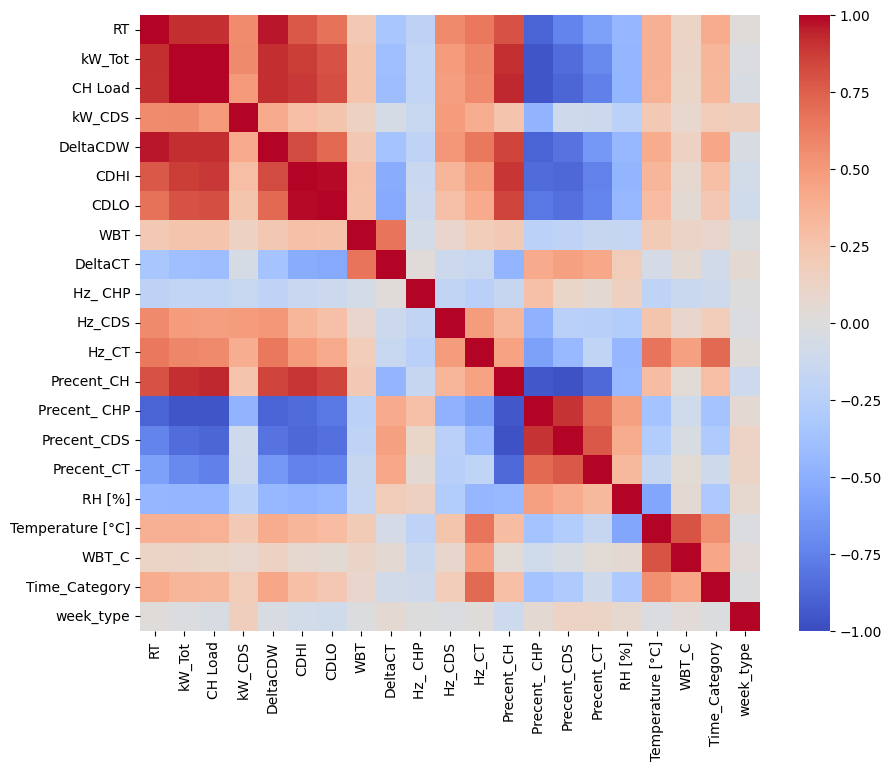

In [171]:
mp.figure(figsize=(10,8))
sns.heatmap(temp_data.corr(),cmap='coolwarm',vmin=-1,vmax=1)

In [172]:
def correlated_feature_pairs(dataset, threshold):
    correlated_pairs = []  # List to store correlated feature pairs
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # We are interested in absolute coeff value
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlated_pairs.append((feature1, feature2))

    return correlated_pairs

# Define a correlation threshold (e.g., 0.9, adjust as needed)
correlation_threshold = 0.9

# Use the function to get the correlated feature pairs
correlated_pairs = correlated_feature_pairs(temp_data, correlation_threshold)

print("Total", len(correlated_pairs), "correlated pairs found.")

# Print the correlated feature pairs
for pair in correlated_pairs:
    print(f"Correlated Pair: {pair[0]} and {pair[1]}")


Total 14 correlated pairs found.
Correlated Pair: kW_Tot and RT
Correlated Pair: CH Load and RT
Correlated Pair: CH Load and kW_Tot
Correlated Pair: DeltaCDW and RT
Correlated Pair: DeltaCDW and kW_Tot
Correlated Pair: DeltaCDW and CH Load
Correlated Pair: CDLO and CDHI
Correlated Pair: Precent_CH and kW_Tot
Correlated Pair: Precent_CH and CH Load
Correlated Pair: Precent_ CHP and kW_Tot
Correlated Pair: Precent_ CHP and CH Load
Correlated Pair: Precent_ CHP and Precent_CH
Correlated Pair: Precent_CDS and Precent_CH
Correlated Pair: Precent_CDS and Precent_ CHP


In [176]:
def correlation_data(data,thresh):
    col_corr = set()
    correlated_pairs = []
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>thresh:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [177]:
corr_features = correlation_data(temp_data,0.9)
len(set(corr_features))

7

In [178]:
corr_features

{'CDLO',
 'CH Load',
 'DeltaCDW',
 'Precent_ CHP',
 'Precent_CDS',
 'Precent_CH',
 'kW_Tot'}

#### Remove all paramters except CH Load and kW_Tot because there two are important in formulation of Plant Efficiency

In [179]:
temp_data = temp_data.drop(columns=['CDLO','DeltaCDW','Precent_ CHP','Precent_CDS','Precent_CH'],axis=1)

In [180]:
temp_data.nunique()

RT                  1825
kW_Tot              1871
CH Load              714
kW_CDS                81
CDHI                 244
WBT                   51
DeltaCT              213
Hz_ CHP                3
Hz_CDS                 4
Hz_CT                  8
Precent_CT           123
RH [%]               352
Temperature [°C]      76
WBT_C                 71
Time_Category          4
week_type              2
dtype: int64

<Axes: >

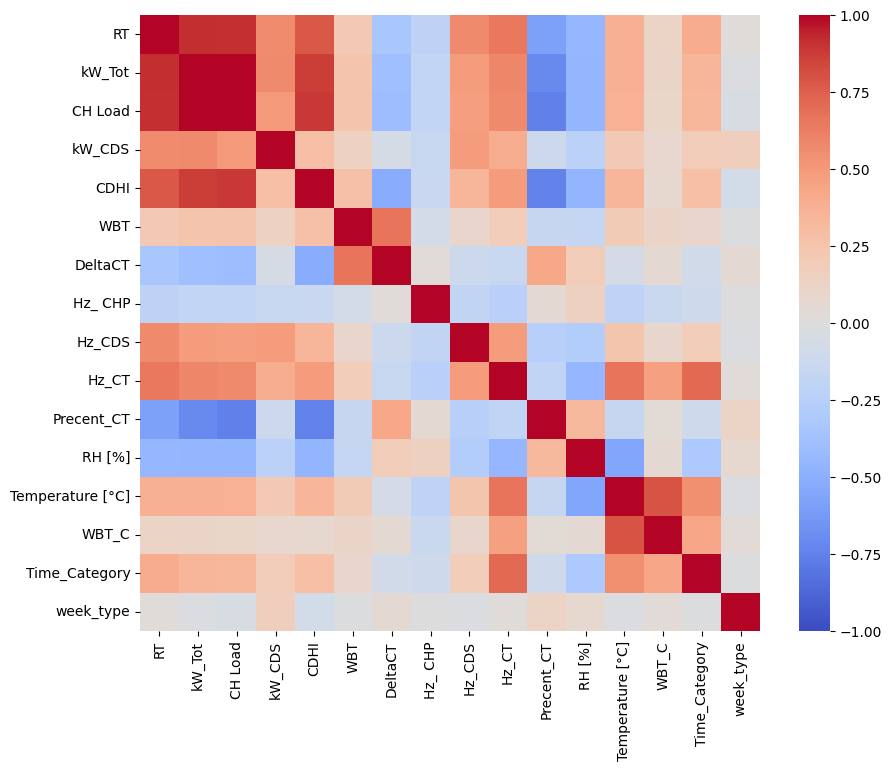

In [181]:
mp.figure(figsize=(10,8))
sns.heatmap(temp_data.corr(),cmap='coolwarm',vmin=-1,vmax=1)

In [182]:
X_temp_data = temp_data.copy()
X_temp_data.shape

(3878, 16)

## Model

In [183]:
X_train, X_test, Y_train, Y_test = train_test_split(X_temp_data, Y, test_size=0.2, random_state=42)

# Output the shape of the splits for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (3102, 16)
X_test shape: (776, 16)
Y_train shape: (3102,)
Y_test shape: (776,)


In [184]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(X_temp_data.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer for continuous prediction
])

# Print model summary to verify
model.summary()


C:\Users\TRIDNT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,763 (45.95 KB)

 Trainable params: 11,327 (44.25 KB)

 Non-trainable params: 436 (1.70 KB)

In [185]:
# Fix: Monitor 'val_loss' or 'val_mean_absolute_error' instead of 'val_accuracy'
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# Compile the model with an appropriate regression loss and metrics
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Fit the model and include the early stopping callback
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.9807 - mean_absolute_error: 1.1082 - val_loss: 0.1471 - val_mean_absolute_error: 0.3492
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7740 - mean_absolute_error: 0.6723 - val_loss: 0.1008 - val_mean_absolute_error: 0.2927
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4350 - mean_absolute_error: 0.4930 - val_loss: 0.0488 - val_mean_absolute_error: 0.1996
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3394 - mean_absolute_error: 0.4256 - val_loss: 0.0151 - val_mean_absolute_error: 0.1016
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2825 - mean_absolute_error: 0.3768 - val_loss: 0.0093 - val_mean_absolute_error: 0.0722
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2026 - mean_absolute_error: 0.3336 - val_loss: 0.0114 - val_mean_absolute_error: 0.0739
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1872 - mean_absolute_error: 0.3113 - val_loss: 0.008

In [186]:
# Evaluate the model on the test data
loss, metric = model.evaluate(X_test, Y_test)

# Print the loss and metric (like accuracy, MAE, etc. depending on what you set)
print(f"Test Loss: {loss}")
print(f"Test Metric: {metric}")  # Metric could be accuracy, MAE, etc.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0382
Test Loss: 0.004367496818304062
Test Metric: 0.04054280370473862


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


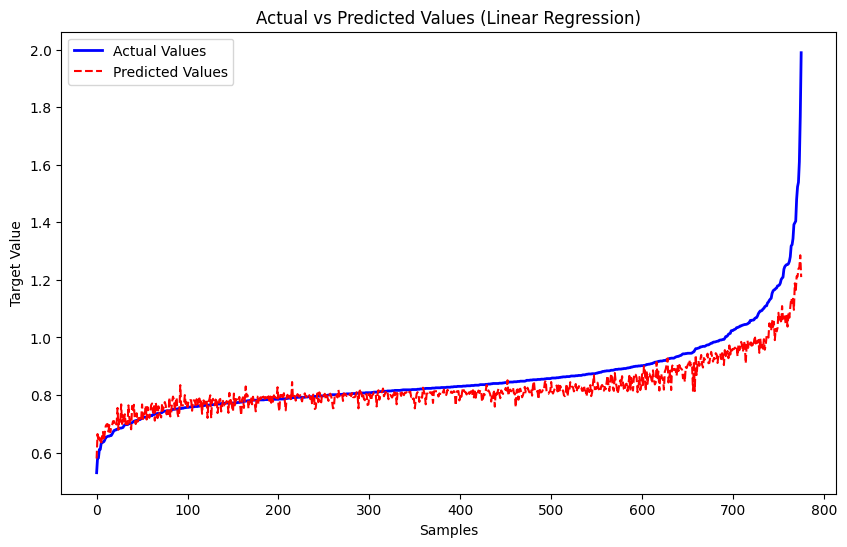

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Convert Y_test to a NumPy array
y_test = np.array(Y_test)

# Predict the values using the model
y_pred = model.predict(X_test)

# Sort the values for better visualization (optional but useful for linear trends)
sorted_idx = np.argsort(y_test)
y_test_sorted = y_test[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.legend()
plt.show()


### Hyper Paramater Tuning

In [146]:
import keras_tuner as kt
from tensorflow import keras

# Define a model builder function for Keras Tuner
def model_builder(hp):
    model = keras.Sequential()

    # Tune the number of units in each Dense layer and dropout rates
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=128, step=16)
    model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.BatchNormalization())
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout_1))

    hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=32)
    model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout_2))

    hp_units_3 = hp.Int('units_3', min_value=16, max_value=64, step=16)
    model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout_3))

    model.add(keras.layers.Dense(1, activation='linear'))  # Output layer for continuous prediction

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

# Initialize the Keras Tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_mean_absolute_error',  # Minimize the mean absolute error for regression
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='chiller_tuning'
)

# Set up early stopping
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}, 
in the second layer is {best_hps.get('units_2')}, 
and in the third layer is {best_hps.get('units_3')}.
The optimal dropout rates are {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')}, and {best_hps.get('dropout_3')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
# history = best_model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[stop_early])


Trial 30 Complete [00h 00m 13s]
val_mean_absolute_error: 0.01694888435304165

Best val_mean_absolute_error So Far: 0.011625498533248901
Total elapsed time: 00h 03m 49s

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 10, 
in the second layer is 64, 
and in the third layer is 16.
The optimal dropout rates are 0.0, 0.2, and 0.1.
The optimal learning rate for the optimizer is 0.01.



C:\Users\TRIDNT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [188]:
history = best_model.fit(X_train, Y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[stop_early])

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0310 - val_loss: 5.4689e-04 - val_mean_absolute_error: 0.0195
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0330 - val_loss: 3.6091e-04 - val_mean_absolute_error: 0.0161
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0303 - val_loss: 5.5333e-04 - val_mean_absolute_error: 0.0201
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0327 - val_loss: 9.2873e-04 - val_mean_absolute_error: 0.0204
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0336 - val_loss: 0.0025 - val_mean_absolute_error: 0.0466


In [190]:
X_train.shape   

(3102, 16)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


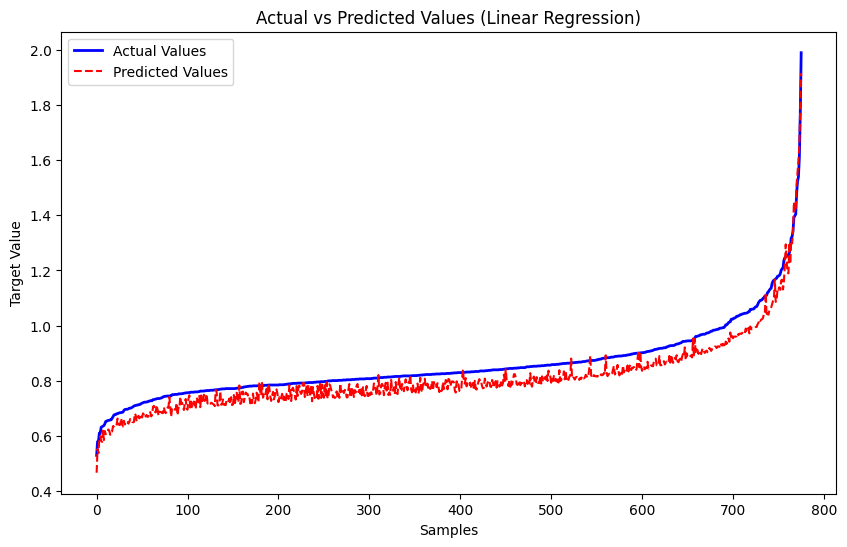

In [189]:
import matplotlib.pyplot as plt
import numpy as np

# Convert Y_test to a NumPy array
y_test = np.array(Y_test)

# Predict the values using the model
y_pred = best_model.predict(X_test)

# Sort the values for better visualization (optional but useful for linear trends)
sorted_idx = np.argsort(y_test)
y_test_sorted = y_test[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.legend()
plt.show()


In [153]:
best_model.save(r'C:\Users\TRIDNT\Documents\Codes_and_Stuff\SelfMadeModels\Best_Plant_Efficiency_Model.keras')

In [155]:
import pandas as pd
from sklearn.model_selection import train_test_split

def preprocess_data(data1, data2, nrows_data2=4000, drop_correlated_columns=True):
    """
    Preprocesses the input datasets by combining, cleaning, and preparing them for ML modeling.
    
    Parameters:
    -----------
    data1: pd.DataFrame
        The first dataset (e.g., plant efficiency).
    data2: pd.DataFrame
        The second dataset (e.g., temperature data).
    nrows_data2: int
        Number of rows to select from the second dataset.
    drop_correlated_columns: bool
        Whether to drop highly correlated columns from the dataset.
    
    Returns:
    --------
    pd.DataFrame
        Preprocessed dataset ready for machine learning.
    """
    # Step 1: Select a subset of data2
    data2_subset = data2.iloc[:nrows_data2].drop(columns=['DateTime'], errors='ignore')
    
    # Step 2: Combine the two datasets
    combined_data = pd.concat([data1, data2_subset], axis=1)
    
    # Step 3: Drop rows with missing values
    combined_data = combined_data.dropna()
    
    # Step 4: Convert 'Time' column to datetime and create new time-related features
    combined_data['Time'] = pd.to_datetime(combined_data['Time'], errors='coerce')
    
    # Define time categorization functions
    def categorize_time(time):
        if pd.isnull(time):
            return None
        if time.hour < 6 or (time.hour == 6 and time.minute == 0):
            return 1
        elif (time.hour == 6 and time.minute > 0) or (time.hour < 12 or (time.hour == 12 and time.minute == 0)):
            return 2
        elif (time.hour == 12 and time.minute > 0) or (time.hour < 18 or (time.hour == 18 and time.minute == 0)):
            return 3
        else:
            return 4

    def classify_week_type(time):
        if pd.isnull(time):
            return None
        return 1 if time.weekday() >= 4 else 0
    
    # Apply the functions to categorize time and week type
    combined_data['Time_Category'] = combined_data['Time'].apply(categorize_time)
    combined_data['Week_Type'] = combined_data['Time'].apply(classify_week_type)
    
    # Drop the 'Time' column after categorization
    combined_data = combined_data.drop(columns=['Time'], errors='ignore')
    
    # Step 5: Rename 'kW_RT' to 'Plant_Efficiency' if it exists
    if 'kW_RT' in combined_data.columns:
        combined_data['Plant_Efficiency'] = combined_data.pop('kW_RT')
    
    # Step 6: Drop specific columns (optional)
    columns_to_drop = ['CH1', 'CH2', 'CH3', 'CH4', 'kW_CHS', 'Hz_CHS']
    combined_data = combined_data.drop(columns=[col for col in columns_to_drop if col in combined_data.columns], errors='ignore')
    
    # Step 7: Remove rows where 'Plant_Efficiency' is zero
    if 'Plant_Efficiency' in combined_data.columns:
        combined_data = combined_data[combined_data['Plant_Efficiency'] != 0]
    
    # Step 8: Drop highly correlated columns if flag is set
    if drop_correlated_columns:
        correlated_columns = correlation_data(combined_data.drop('Plant_Efficiency', axis=1), thresh=0.9)
        combined_data = combined_data.drop(columns=correlated_columns)
    
    # Step 9: Remove specific additional columns
    additional_columns_to_drop = ['GPM', 'DeltaCHW', 'CHWS', 'CHWR', 'kW_CHH', 'kW_CHP', 'kW_CT', 
                                  'CDLO', 'DeltaCDW', 'Precent_CHP', 'Precent_CDS', 'Precent_CH']
    combined_data = combined_data.drop(columns=[col for col in additional_columns_to_drop if col in combined_data.columns], errors='ignore')

    return combined_data

def correlation_data(data, thresh=0.9):
    """
    Identifies columns that are highly correlated with others.
    
    Parameters:
    -----------
    data: pd.DataFrame
        The dataset to check for multicollinearity.
    thresh: float
        The threshold for correlation. Columns with a correlation higher than this will be dropped.
    
    Returns:
    --------
    set
        A set of column names that are highly correlated.
    """
    col_corr = set()  # Set of correlated columns to remove
    corr_matrix = data.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > thresh:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    
    return col_corr

def split_data(data, target_column, test_size=0.2, random_state=42):
    """
    Splits the preprocessed data into training and testing sets.
    
    Parameters:
    -----------
    data: pd.DataFrame
        The preprocessed dataset ready for ML.
    target_column: str
        The name of the target column to be predicted (e.g., 'Plant_Efficiency').
    test_size: float
        The proportion of the dataset to include in the test split.
    random_state: int
        Controls the shuffling applied to the data before splitting. Pass an int for reproducible output.
    
    Returns:
    --------
    X_train, X_test, Y_train, Y_test: pd.DataFrame
        Features and target variables split into training and testing sets.
    """
    X = data.drop(target_column, axis=1)
    Y = data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test


# Example Usage:
# Load your data
data1 = pd.read_csv(r"C:\Users\TRIDNT\Documents\Codes_and_Stuff\Datasets\PLANT TON_EFFICIENCY_TEMPERATURE\PLANT TON_EFFICIENCY\TableData (6).csv")
data2 = pd.read_excel(r"C:\Users\TRIDNT\Documents\Codes_and_Stuff\Datasets\PLANT TON_EFFICIENCY_TEMPERATURE\TEMPERATURE\ECCO 19400(19400) sensors data (3).xlsx",engine='openpyxl')

# Preprocess the data
preprocessed_data = preprocess_data(data1, data2)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = split_data(preprocessed_data, target_column='Plant_Efficiency')


In [157]:
X_train.shape[1]

14

In [ ]:
history = best_model.fit(X_train, Y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[stop_early])